In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
%matplotlib inline

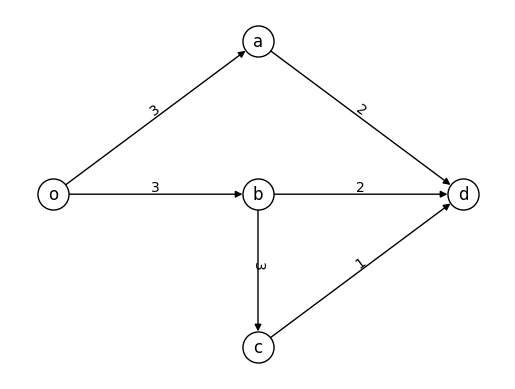

In [2]:
#building the graph based on question
# o>a:e1 a>d:e2 o>b:e3 b>d:e4 b>c:e5 c>d:e6
G = nx.DiGraph()
G.add_edges_from([('o','a'),('a','d'),('o','b'),('b','d'),('b','c'),('c','d')])
pos = {'o': [0,1], 'a': [1,2], 'b': [1,1], 'c': [1,0], 'd': [2,1]}

#assosiating capacites c1 to c6 respectively
G['o']['a']['capacity'] = 3
G['a']['d']['capacity'] = 2
G['o']['b']['capacity'] = 3
G['b']['d']['capacity'] = 2
G['b']['c']['capacity'] = 3
G['c']['d']['capacity'] = 1

node_style = {
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
}
edge_labels = {(u, v): str(d['capacity']) for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G,pos, edge_labels=edge_labels, font_color='black',verticalalignment="bottom")
nx.draw(G, pos, with_labels = True, **node_style)

In [3]:
cut_value, partition = nx.minimum_cut(G, 'o', 'd')
print("Minimum cut value:", cut_value)
print("Source side of the cut:", partition[0])
print("Sink side of the cut:", partition[1])

Minimum cut value: 5
Source side of the cut: {'c', 'o', 'b', 'a'}
Sink side of the cut: {'d'}


In [4]:
#this is a function that check all edges to find the maximum capacity exist in graph
def maxCapacity(G):
    maxCapacity = 0
    for e in list(G.edges):
        if maxCapacity < G[e[0]][e[1]]['capacity']:
            maxCapacity = G[e[0]][e[1]]['capacity']
    return maxCapacity

In [5]:
G1 = nx.DiGraph(G)
edges = list(G1.edges())  #assuming G1 is the new graph same as one we have because we dont eant to change the main one.
maxCap = maxCapacity(G)
aggrCapacity = 0
initalMaxFlow = nx.minimum_cut_value(G, "o", "d")
edges = list(G.edges)
ListOfEdgesDecreased = []

#keep track of edges whose capacity couldn't be decreased
unchangeable_edges = set()

for cap in range(1, maxCap + 1):
    for e in edges:
        if e in unchangeable_edges:
            continue  #skip edges whose capacity couldn't be decreased previously

        #decrease capacity by one
        G1[e[0]][e[1]]['capacity'] -= 1

        #compute the maxFlow
        maxFlow = nx.minimum_cut_value(G1, "o", "d")

        if maxFlow != initalMaxFlow or G1[e[0]][e[1]]['capacity'] < 0:
            #if reducing capacity affects flow or capacity becomes negative,
            #revert the capacity back and mark the edge as unchangeable
            G1[e[0]][e[1]]['capacity'] += 1
            unchangeable_edges.add(e)
        else:
            #capacity successfully decreased
            ListOfEdgesDecreased.append(e[0] + "-" + e[1])
            aggrCapacity += 1
#print the total aggregate capacity
print('aggrigation of capacity  can be removed', aggrCapacity)
print('list of edges which the capacity is removed from', ListOfEdgesDecreased)



aggrigation of capacity  can be removed 3
list of edges which the capacity is removed from ['o-a', 'b-c', 'b-c']


In [6]:
#to iterate on graph linkes; retriving the attrebute of each tuple of nodes for each eadge:
def info(G):
    value, sets_edges = nx.minimum_cut(G, "o", "d")
    print("Values of min-cut:", value, ". Sets of vertexes obtained: ",  sets_edges)
    for e in list(nx.edges(G)):
        print(e,G[e[0]][e[1]])

In [7]:
#this function calculate the intersection of two given list
def intersection(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    return list(set1.intersection(set2))

In [8]:
#get the edges belonging to the shortest path
def shortest_paths_edges(G):
    shortest_paths = [p for p in nx.all_shortest_paths(G, source='o', target='d')]
    list = []
    for shortest_path_vertexes in shortest_paths:
        for vertex_pos in range(len(shortest_path_vertexes) - 1):
            edge = (shortest_path_vertexes[vertex_pos], shortest_path_vertexes[vertex_pos + 1])
            list.append(edge)
    return list

In [9]:
def find_cut_edges(G, source, sink):
    #find the minimum cut edges
    cut_value, partition = nx.minimum_cut(G, source, sink)

    #extract nodes on either side of the cut
    source_partition = partition[0]
    sink_partition = partition[1]

    #find edges that go from source to sink partitions
    cut_edges = []
    for u, v in G.edges():
        if u in source_partition and v in sink_partition:
            cut_edges.append((u, v))

    return cut_edges

In [10]:
def adding_Capacity_Optimizer(G, x):
    oldMinCutV = nx.minimum_cut_value(G, "o", "d")

    for capacity_unit in range(1, x + 1):
        print('\nAdding x =', capacity_unit, 'capacity')
        intersection_edges = intersection(find_cut_edges(G, "o", "d"), shortest_paths_edges(G))

        #calculate change in flow across edges in the minimum cut due to temporary capacity increase
        flow_changes = {}
        for edge in intersection_edges:
            G[edge[0]][edge[1]]['capacity'] += 1
            newMinCutV = nx.minimum_cut_value(G, "o", "d")
            flow_changes[edge] =  newMinCutV - oldMinCutV
            G[edge[0]][edge[1]]['capacity'] -= 1

        #calculate capacity-to-flow-change ratio
        capacity_flow_change_ratios = {}
        for edge, flow_change in flow_changes.items():
            remaining_capacity = G[edge[0]][edge[1]]['capacity']
            capacity_flow_change_ratios[edge] = remaining_capacity / (flow_change + 1)  # Adding 1 to avoid division by zero

        #prioritize edges with higher capacity to flow-change ratios
        for edge, ratio in sorted(capacity_flow_change_ratios.items(), key=lambda item: item[1], reverse=True):
            G[edge[0]][edge[1]]['capacity'] += 1
            print('Capacity added to edge:', edge[0], '-', edge[1])
            break

    # retrive final new  minimum cut value after all capacity additions
    newMinCutV = nx.minimum_cut_value(G, "o", "d")
    return newMinCutV



Adding x = 1 capacity
Capacity added to edge: b - d

Adding x = 1 capacity
Capacity added to edge: b - d

Adding x = 2 capacity
Capacity added to edge: o - b

Adding x = 1 capacity
Capacity added to edge: b - d

Adding x = 2 capacity
Capacity added to edge: o - b

Adding x = 3 capacity
Capacity added to edge: b - d

Adding x = 1 capacity
Capacity added to edge: b - d

Adding x = 2 capacity
Capacity added to edge: o - b

Adding x = 3 capacity
Capacity added to edge: b - d

Adding x = 4 capacity
Capacity added to edge: o - b

Adding x = 1 capacity
Capacity added to edge: b - d

Adding x = 2 capacity
Capacity added to edge: o - b

Adding x = 3 capacity
Capacity added to edge: b - d

Adding x = 4 capacity
Capacity added to edge: o - b

Adding x = 5 capacity
Capacity added to edge: b - d

Adding x = 1 capacity
Capacity added to edge: b - d

Adding x = 2 capacity
Capacity added to edge: o - b

Adding x = 3 capacity
Capacity added to edge: b - d

Adding x = 4 capacity
Capacity added to edge:

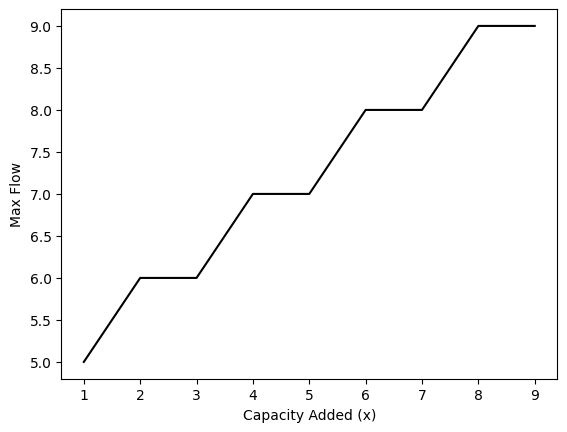

In [11]:
#create arrays to plot the results
y = []
for x in range(1, 10):
    G1 = nx.DiGraph(G)
    y.append(adding_Capacity_Optimizer(G1, x))
x = [*range(1, 10)]
print(x, '\n', y)
plt.plot(x, y, color="black")

plt.xlabel('Capacity Added (x)')
plt.ylabel('Max Flow')

plt.show()

In [12]:
G = nx.Graph()
original_edges = [('p1','b1'), ('p1','b2'), ('p2','b2'), ('p2','b3'), ('p3','b4'),\
                  ('p3','b1'), ('p4','b1'), ('p4','b2'), ('p4','b4')]
added_edges = [('o', 'p1'), ('o', 'p2'), ('o', 'p3'), ('o', 'p4'),
                  ('d', 'b1'), ('d', 'b2'), ('d', 'b3'), ('d', 'b4')]

G.add_edges_from(original_edges)
G.add_edges_from(added_edges)
pos = {'o':[-2, 3], 'p1':[0,0], 'p2':[0,2], 'p3':[0,4], 'p4':[0,6], 'b1':[2,0], 'b2':[2,2], 'b3':[2,4], 'b4':[2,6], 'd':[4,3] }

Matched pairs:
p2 matched with b3
p1 matched with b2
p3 matched with b4
p4 matched with b1


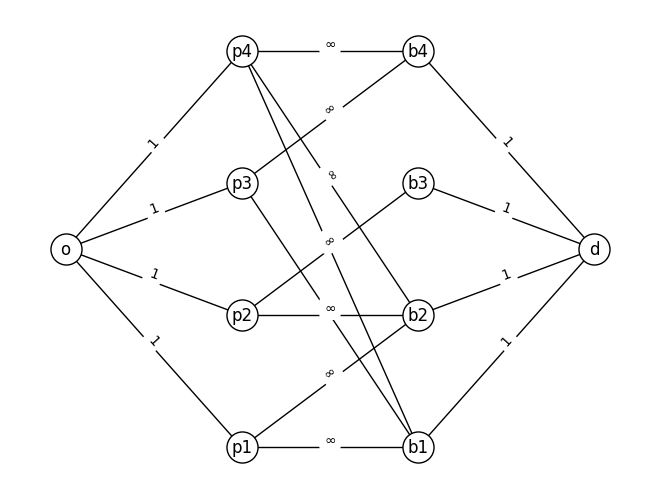

In [13]:

#assigning infinite capacity to the original edges of the graph
for e in original_edges:
    G[e[0]][e[1]]['capacity'] = math.inf

#assigning one capacity to the original edges of the graph
for e in added_edges:
    G[e[0]][e[1]]['capacity'] = 1

numberOfPeople = []
#iterate over the original_edges in order to get the all vertixes representing a person
for e in original_edges:
    if e[0][0] == 'p':
        numberOfPeople.append(e[0])

    if e[1][0] == 'p':
        numberOfPeople.append(e[1])

numberOfBooks= []
#iterate over the original_edges in order to get the all vertixes representing a book
for e in original_edges:
    if e[0][0] == 'b':
        numberOfBooks.append(e[0])

    if e[1][0] == 'b':
        numberOfBooks.append(e[1])

#making sure no person or book appears more then one time
people = list(set(numberOfPeople))
books = list(set(numberOfBooks))


#number of people =  minimum cut? if yes perfect matching exist
if nx.minimum_cut_value(G, "o", "d") == len(numberOfPeople) and len(numberOfPeople) == len(numberOfBooks):
    print('perfect matching exist !')

# as we have already confirmed a perfect matching and computed the maximum flow

flow_values = nx.maximum_flow(G, "o", "d")[1]

matches = []
for person in people:
    for book in books:
        if person in flow_values and book in flow_values[person] and flow_values[person][book] > 0:
            matches.append((person, book))

print("Matched pairs:")
for person, book in matches:
    print(f"{person} matched with {book}")

# Replace math.inf with a custom string representation
for e in original_edges:
    G[e[0]][e[1]]['capacity'] = "∞"

# Draw graph
edge_labels = {(u, v): str(d['capacity']) for u, v, d in G.edges(data=True)}
nx.draw(G, pos, with_labels=True, **node_style)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', verticalalignment="bottom")
#assigning infinite capacity  again to the original edges of the graph to not making mistake afterwards.
for e in original_edges:
    G[e[0]][e[1]]['capacity'] = math.inf
plt.show()

In [14]:
G['b1']['d']['capacity'] = 2
G['b2']['d']['capacity'] = 3
G['b3']['d']['capacity'] = 2
G['b4']['d']['capacity'] = 2
G['o']['p1']['capacity'] = 2
G['o']['p2']['capacity'] = 2
G['o']['p3']['capacity'] = 2
G['o']['p4']['capacity'] = 3

for e in original_edges:
    G[e[0]][e[1]]['capacity'] = 1



#the new maximum capacity is 8, so all books but one have been succesfully assigned
print(f"Number of matches found: {nx.minimum_cut_value(G, 'o', 'd')}")
flow_values = nx.maximum_flow(G, "o", "d")[1]

matches = []
for person in people:
    for book in books:
        if person in flow_values and book in flow_values[person] and flow_values[person][book] > 0:
            matches.append((person, book))

print("Matched pairs:")
for person, book in matches:
    print(f"{person} matched with {book}")

Number of matches found: 8
Matched pairs:
p2 matched with b3
p2 matched with b2
p1 matched with b2
p3 matched with b4
p3 matched with b1
p4 matched with b4
p4 matched with b2
p4 matched with b1


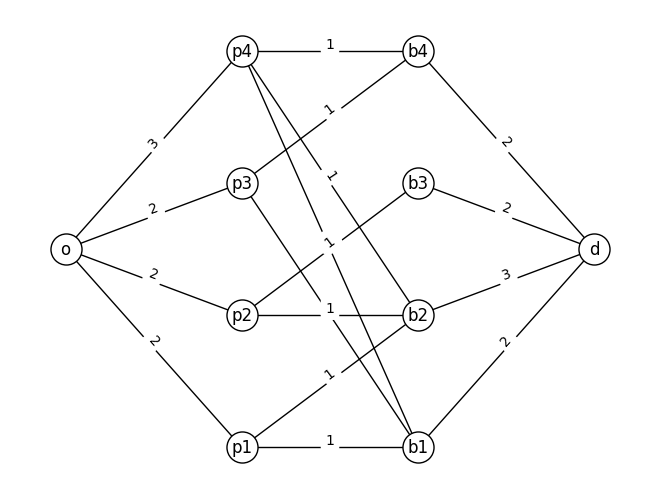

In [15]:
# Draw graph
edge_labels = {(u, v): str(d['capacity']) for u, v, d in G.edges(data=True)}
nx.draw(G, pos, with_labels=True, **node_style)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', verticalalignment="bottom")
plt.show()

In [16]:
#making a new assignment of capacity to books or d side
new_copies = [3, 3, 1, 2]

G['b1']['d']['capacity'] = 3
G['b2']['d']['capacity'] = 3
G['b3']['d']['capacity'] = 1
G['b4']['d']['capacity'] = 2

#the new maximum capacity is 9 now
print(f"Number of matches found: {nx.minimum_cut_value(G, 'o', 'd')}")

Number of matches found: 9


In [17]:
import numpy as np
import scipy
import cvxpy as cp

#read all files
f = scipy.io.loadmat('flow.mat')["flow"].reshape(28,)
C = scipy.io.loadmat('capacities.mat')["capacities"].reshape(28,)
B = scipy.io.loadmat('traffic.mat')["traffic"]
l = scipy.io.loadmat('traveltime.mat')["traveltime"].reshape(28,)

In [27]:
n_edges = B.shape[1] #number of edges we have
tau = 1 #constant number we have in optimization
nu = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]) * tau
f = cp.Variable(n_edges)
objective = cp.Minimize(l.T @ f)
#we define the constrains and objective
#ensures that the flow equation is satisfied, where B is the incidence matrix of the graph
constraints = [B @ f == nu, f >=0, f <= C]
prob = cp.Problem(objective, constraints)
result = prob.solve()
rounded_opt_f = [round(v) for v in f.value] #change probs to 1 or 0
print("Optimal f:", rounded_opt_f)

shortest_path = []

for i in range(B.shape[1]):

  for j in range(B.shape[0]):

    if B[j][i] == 1:
      v1 = j+1

    if B[j][i] == -1:
      v2 = j+1

  if rounded_opt_f[i] == 1:
    shortest_path.append((v1,v2))


print("shortest path:", shortest_path)

Optimal f: [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
shortest path: [(1, 2), (2, 3), (9, 13), (3, 9), (13, 17)]


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [29]:
n_edges = B.shape[1]
tau = 1
#in order to find the maximum capacity we iterate over a range of probable
#maximum flow values
for x in range(20000, 30000):
    nu = np.array([x, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -x]) * tau
    f = cp.Variable(n_edges)
    I = np.ones(n_edges)
    objective = cp.Maximize(I@f)
    constraints = [B @ f == nu, f >=0, f <= C]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    #if None values is returned the maximum capacity is reached in the previous cycle
    #therefore is enough to select the flow of the previous cycle subtracting one
    if f.value is None:
        x = x - 1
        print('max flow is:', x)
        break

max flow is: 22448


In [34]:
f = scipy.io.loadmat('flow.mat')["flow"].reshape(28,)
v = B@f
v


array([ 16282,   9094,  19448,   4957,   -746,   4768,    413,     -2,
        -5671,   1169,     -5,  -7131,   -380,  -7412,  -7810,  -3430,
       -23544], dtype=int32)

In [32]:

n_edges = B.shape[1]
print(n_edges)
tau = v[0]
nu = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]) * tau
f = cp.Variable(n_edges)
I = np.ones(n_edges)
objective = cp.Minimize((l*C)@cp.inv_pos(I - f/C) - l.T@C)
constraints = [B @ f == nu, f >=0, f <= C]
prob = cp.Problem(objective, constraints)
prob.solve()
not_rounded_optimal_f = f.value
optimal_f = [round(v) for v in f.value]
print("Optimal f:", optimal_f)

28
Optimal f: [6454, 5919, 2995, 2995, 9828, 4497, 2897, 2436, 3047, 535, 0, 2924, 0, 2995, 5331, 2731, 4734, 2134, 461, 2313, 3192, 5505, 2311, 0, 6242, 5306, 4734, 4734]


In [35]:

n_edges = B.shape[1]
print(n_edges)
tau = v[0]
nu = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]) * tau
f = cp.Variable(n_edges)
I = np.ones(n_edges)
objective = cp.Minimize(((l*C).T @ (cp.log(C) - cp.log(C - f))))
constraints = [B @ f == nu, f >=0, f <= C -1]
prob = cp.Problem(objective, constraints)
prob.solve()
wardrop_f = [round(v) for v in f.value]
print("wardrop_flow:", wardrop_f)

28
wardrop_flow: [6532, 6532, 2207, 2207, 9750, 4493, 2714, 2204, 3343, 0, 189, 4137, 0, 2207, 5256, 2247, 4788, 1779, 699, 2998, 2947, 5945, 2508, 0, 6779, 4715, 4788, 4788]


In [36]:
#function that calculates the social optimum cost.
def tot_cost(f, l, c):
  return np.sum(((l*c)/(np.ones(len(f))- f/c)) - l*c)


wardrop_cost = tot_cost(f = wardrop_f, l=l, c=C)
print("Wardrop cost:", wardrop_cost)

Wardrop cost: 24161.858264129027


In [39]:
#omega is defined and added to the objective function.
omegas = ((l*(C) / (C - not_rounded_optimal_f)**2))* not_rounded_optimal_f
objective = cp.Minimize(((l*C).T @ (cp.log(C) - cp.log(C - f)))  + omegas.T@f ) #the result of the sum of the costs.
prob = cp.Problem(objective, constraints)
prob.solve()
wardrop_flow_with_tolls = [round(v) for v in f.value]

print(wardrop_flow_with_tolls)

[6454, 5919, 2995, 2995, 9828, 4497, 2897, 2436, 3047, 535, 0, 2924, 0, 2995, 5331, 2731, 4734, 2134, 461, 2313, 3192, 5505, 2311, 0, 6242, 5306, 4734, 4734]


In [40]:
wardrop_cost = tot_cost(f = wardrop_flow_with_tolls, l=l, c=C) #cost funxtion(tridente) is always t5he same
print("Wardrop cost:", wardrop_cost)

Wardrop cost: 23834.557573649894


In [41]:
#we have to recompute everything using the new cost function
f = cp.Variable(n_edges)
objective = cp.Minimize(((cp.inv_pos(np.ones(n_edges)-(f/C))).T@(l*C))-l.T@C -l.T@f)
constraints = [B @ f == nu, f >=0, f <= C]
prob = cp.Problem(objective, constraints)
result = prob.solve()
comparison_opt_flow = f.value
#rounding
rounded_opt_flow = [round(v) for v in comparison_opt_flow]
print("Optimal f:", rounded_opt_flow)
print("Optimal flow cost:", result)

Optimal f: [6468, 5618, 3298, 3298, 9814, 4502, 3003, 2564, 2918, 850, 0, 2320, 0, 3298, 5312, 2932, 4730, 2349, 439, 1967, 3370, 5337, 2143, 0, 6112, 5441, 4730, 4730]
Optimal flow cost: 13334.304868886004


In [42]:
#let's define the new omegas using the new social optimal flow
omegas_comparison = ((l*(C) / (C - comparison_opt_flow)**2)) * comparison_opt_flow
objective = cp.Minimize((C*l).T @ (cp.log(C) - cp.log(C-f)) -l.T@f +  omegas_comparison.T@f )
prob = cp.Problem(objective, constraints)
tolls_result = prob.solve()
flow_with_tolls = f.value
#rounding
rounded_tolls_flow = [round(v) for v in flow_with_tolls]
print("Wardrop f with tolls:", rounded_tolls_flow)

Wardrop f with tolls: [6468, 5618, 3297, 3297, 9814, 4502, 3003, 2564, 2918, 850, 0, 2321, 0, 3297, 5312, 2931, 4730, 2349, 439, 1967, 3370, 5337, 2143, 0, 6112, 5441, 4730, 4730]


In [43]:
def comparison_cost(f, l, c):
  return np.sum(((l*c)/(np.ones(len(f))- f/c)) - l*c - l*f)


tolls_cost = comparison_cost(f = flow_with_tolls, l=l, c=C)

print("Wardrop cost with tolls:", tolls_cost)

Wardrop cost with tolls: 13334.304624997643
